In [2]:
import numpy as np

import matplotlib.pyplot as plt

from robot_arm import RobotArm

Implementation of Cyclic Coordinate Descent (or CCD) for solving the inverse kinematics problem for a robot arm with n joints

We are using numpy as the base library as matplotlib for drawing the robot arm

First implement the render functions to display the stuff


In [3]:
def draw(robot_arm: RobotArm, goal: np.array):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlim(-robot_arm.n_joints, robot_arm.n_joints)
    ax.set_ylim(-robot_arm.n_joints, robot_arm.n_joints)
    ax.grid()

    # plot goal position
    ax.plot(goal[0], goal[1], marker="o")
    for joint_idx in range(robot_arm.n_joints):
        origin = robot_arm._positions[joint_idx]
        next_point = robot_arm._positions[joint_idx + 1]

        ax.plot([origin[0], next_point[0]], [origin[1], next_point[1]], "k-o")

implement a function to sample uniform a target position

In [4]:
def sample_goal(radius: float):
    """
    sample goal position in a circular shape around the origin
    """
    # angle to sample from
    theta = np.random.uniform(0, 2 * np.pi)
    radius = np.random.uniform(0, radius)

    return radius * np.array([np.cos(theta), np.sin(theta)])

implement a function to get the angle between two vectors

In [5]:
def angle(v1, v2):
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    return np.arccos(np.dot(v1_norm, v2_norm))

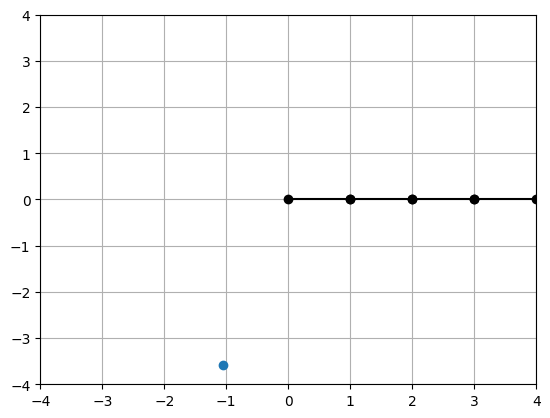

In [6]:
n_joints = 4
arm = RobotArm(n_joints=n_joints)
goal = sample_goal(n_joints)

draw(arm, goal)

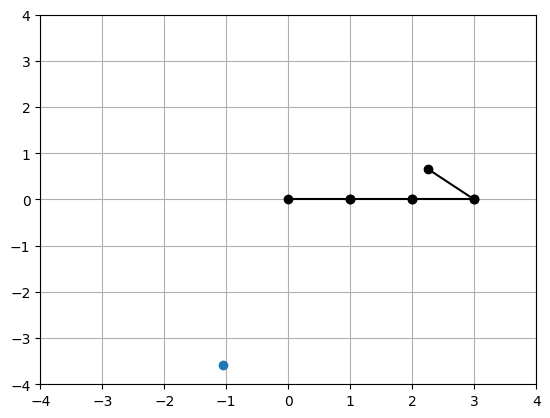

In [7]:
# turn last joint towards goal position
target_vector = goal - arm._positions[-2]
joint_vector = arm._positions[-1] - arm._positions[-2]
target_angle = angle(target_vector, joint_vector)

action = arm.angles
action[-1] += target_angle

arm.set(action)

draw(arm, goal)

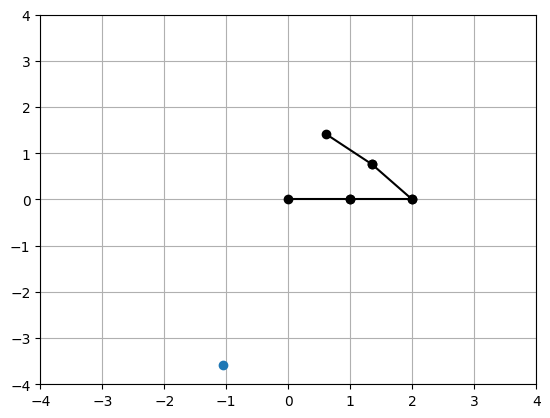

In [8]:
# turn last joint towards goal position
target_vector = goal - arm._positions[-3]
joint_vector = arm._positions[-2] - arm._positions[-3]
target_angle = angle(target_vector, joint_vector)

action = arm.angles
action[-2] += target_angle

arm.set(action)

draw(arm, goal)

In [9]:
import math


def rotateZ(theta):
    rz = np.array(
        [
            [math.cos(theta), -math.sin(theta), 0, 0],
            [math.sin(theta), math.cos(theta), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )
    return rz


def translate(dx, dy, dz):
    t = np.array([[1, 0, 0, dx], [0, 1, 0, dy], [0, 0, 1, dz], [0, 0, 0, 1]])
    return t


# Forward Kinematics
# Input initial angles and length of links
# Output positions each points
def FK(angle, link):
    n_links = len(link)
    P = []
    P.append(np.eye(4))
    for i in range(0, n_links):
        R = rotateZ(angle[i] / 180 * math.pi)
        T = translate(link[i], 0, 0)
        P.append(P[-1].dot(R).dot(T))
    return P


def IK(target, angle, link, max_iter=10000, err_min=0.1):
    solved = False
    err_end_to_target = math.inf

    for loop in range(max_iter):
        for i in range(len(link) - 1, -1, -1):
            P = FK(angle, link)
            end_to_target = target - P[-1][:3, 3]
            err_end_to_target = math.sqrt(end_to_target[0] ** 2 + end_to_target[1] ** 2)
            if err_end_to_target < err_min:
                solved = True
            else:
                # Calculate distance between i-joint position to end effector position
                # P[i] is position of current joint
                # P[-1] is position of end effector
                cur_to_end = P[-1][:3, 3] - P[i][:3, 3]
                cur_to_end_mag = math.sqrt(cur_to_end[0] ** 2 + cur_to_end[1] ** 2)
                cur_to_target = target - P[i][:3, 3]
                cur_to_target_mag = math.sqrt(
                    cur_to_target[0] ** 2 + cur_to_target[1] ** 2
                )

                end_target_mag = cur_to_end_mag * cur_to_target_mag

                if end_target_mag <= 0.0001:
                    cos_rot_ang = 1
                    sin_rot_ang = 0
                else:
                    cos_rot_ang = (
                        cur_to_end[0] * cur_to_target[0]
                        + cur_to_end[1] * cur_to_target[1]
                    ) / end_target_mag
                    sin_rot_ang = (
                        cur_to_end[0] * cur_to_target[1]
                        - cur_to_end[1] * cur_to_target[0]
                    ) / end_target_mag

                rot_ang = math.acos(max(-1, min(1, cos_rot_ang)))

                if sin_rot_ang < 0.0:
                    rot_ang = -rot_ang

                # Update current joint angle values
                angle[i] = angle[i] + (rot_ang * 180 / math.pi)

                if angle[i] >= 360:
                    angle[i] = angle[i] - 360
                if angle[i] < 0:
                    angle[i] = 360 + angle[i]

        if solved:
            break

    return angle, err_end_to_target, solved, loop

[ 5.8841063  15.13014562 26.70933224 79.22421829]
[  5.8841063   21.01425192  47.72358415 126.94780244]
[  5.8841063   21.01425192  47.72358415 126.94780244]


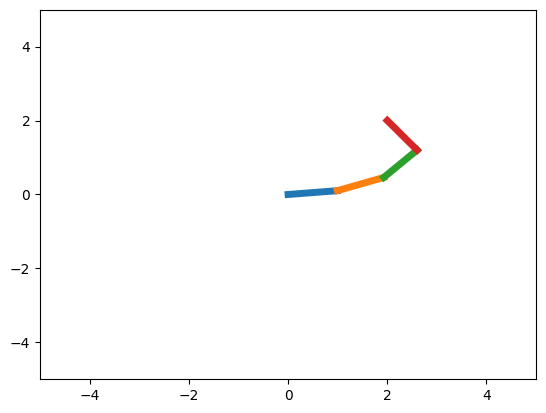

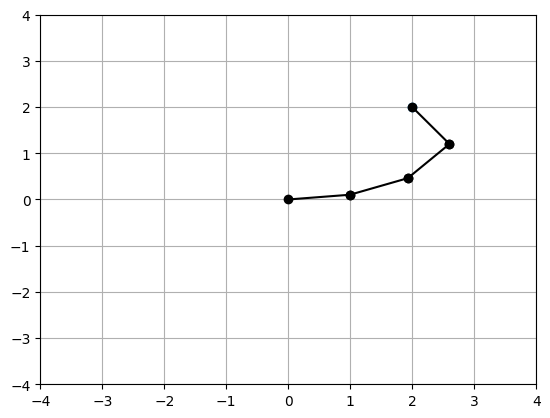

In [10]:
n_joints = 4
link = np.ones(n_joints)
angle = np.zeros(n_joints)

target = [2, 2, 0]

angle, error, _, _ = IK(target, angle, link, err_min=0.001)
print(angle)

# draw(arm2, target)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
P = FK(angle, link)
abs_angles = np.zeros(n_joints)
for i in range(len(link)):
    start_point = P[i]
    end_point = P[i + 1]
    x1 = start_point[0, 3]
    x2 = end_point[0, 3]
    y1 = start_point[1, 3]
    y2 = end_point[1, 3]
    ax.plot([x1, x2], [y1, y2], linewidth=5)

    x_delta = x2 - x1
    y_delta = y2 - y1
    abs_angles[i] = np.arctan2(y_delta, x_delta)

print(abs_angles * 180 / np.pi)
print(angle.cumsum())
abs_angles = angle.cumsum() / 180 * np.pi
arm2 = RobotArm(n_joints)
arm2.set(abs_angles)

draw(arm2, target)

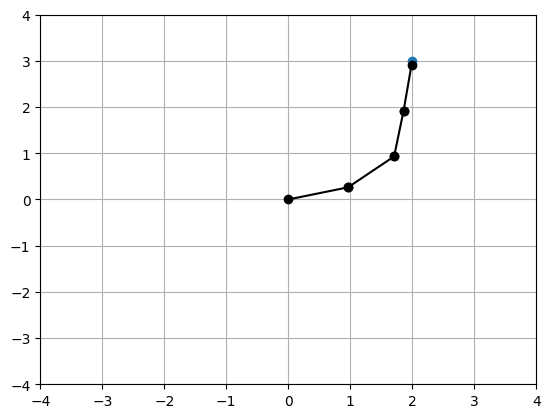

In [16]:
arm3 = RobotArm(4)
target = [2, 3, 0]

arm3.IK(target)
draw(arm3, target)